In [1]:
import os
import math
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
import torch
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

In [2]:
plt.style.use([hep.style.ROOT, hep.style.firamath])
plt.rcParams.update({'lines.markersize': 6})
plt.rcParams.update({'errorbar.capsize': 8})
plt.rcParams.update({'lines.linewidth': 2})

In [3]:
# from src.models import TranAD, iTransformer

In [4]:
modes = ['local (incl. OR)', 'local (maj. voting)', 'global']

## read results

In [5]:
datasets = ['creditcard_normal', 'GECCO_normal', 'IEEECIS_new2.2', 'MSL_new', 'SMAP_new', 'SMD', 'SWaT', 'SWaT_1D', 'UCR', 'WADI']
# ['creditcard', 'creditcard_normal', 'GECCO', 'GECCO_normal', 'IEEECIS_new2.2', 'MSL_new', 'SMAP_new', 'SMD', 'SWaT', 'SWaT_1D', 'UCR', 'WADI']
modeltype = 'TranAD'
reco = True

In [10]:
all_results = {dataset: {} for dataset in datasets}

for dataset in datasets:
    config = {}

    print(f'Loading {dataset}')
    if reco:
        if modeltype == 'Transformer':
            paths = glob.glob(f'{modeltype}/{modeltype}_{dataset}/*' )
        elif modeltype == 'None':
            paths = glob.glob(f'{modeltype}/{modeltype}_{dataset}/' )
        elif modeltype == 'TranAD':
            paths = glob.glob(f'{modeltype}_results_lxplus_eps10/{modeltype}_{dataset}/*' )
            # paths = glob.glob(f'{modeltype}_results_lxplus/{modeltype}_{dataset}/' )  # up to 100 epochs with early stopping
        elif modeltype == 'IF':
            paths = glob.glob(f'{modeltype}/{modeltype}_{dataset}/' )
        else:
            paths = glob.glob(f'{modeltype}_paramsearch_reco_lxplus/{modeltype}_{dataset}/*' )
            # paths = glob.glob(f'{modeltype}_new/{modeltype}_{dataset}/*' )
    else:
        paths = glob.glob(f'{modeltype}_paramsearch_fc_lxplus/{modeltype}_{dataset}/*' )
    paths = [p for p in paths if not '.txt' in p]
    paths = sorted(paths)
    print(len(paths)) 
    # print(paths)

    for path in paths:
        key = path.split('/')[2]
        if modeltype == 'TranAD':
            # path = glob.glob(f'{path}/n_window*/results/')
            path = glob.glob(f'{path}/rep_*/results/')
        elif modeltype in ['IF', 'None']:
            path = glob.glob(f'{path}/feats*/')
        else:
            path = glob.glob(f'{path}/rep_*/results/')  # will give all 5 repetitions
        path = sorted(path)
        # print(path)

        tmp = pd.DataFrame()
        for i, rep_path in enumerate(path):
            res_path = os.path.join(rep_path, 'res.csv')
            print(res_path)
            if not os.path.exists(res_path):
                print(f'Skipping {key} rep {i+1}')
                continue
            res = pd.read_csv(res_path).iloc[-3:]
            tmp = pd.concat((tmp, res))
        
        # print(len(tmp))
        if modeltype == 'IF':
            tmp = tmp.iloc[-1:]
            tmp = tmp.rename(columns={'Unnamed: 0': 'mode'})
            mean_values = tmp.groupby('mode').mean()
            std_values = tmp.groupby('mode').std()
            median_values = tmp.groupby('mode').median()
            mean_values = mean_values.reindex(['global'])
            std_values = std_values.reindex(['global'])
            median_values = median_values.reindex(['global'])
        else:
            tmp.rename(columns={'Unnamed: 0': 'mode'}, inplace=True)
            mean_values = tmp.groupby('mode').mean()
            std_values = tmp.groupby('mode').std()
            median_values = tmp.groupby('mode').median()
            mean_values = mean_values.reindex(['local_all', 'local_all_maj', 'global'])
            std_values = std_values.reindex(['local_all', 'local_all_maj', 'global'])
            median_values = median_values.reindex(['local_all', 'local_all_maj', 'global'])
        if modeltype in ['IF', 'None']:
            feats_value = -1
            eps_value = 0
            window_value = 10
            steps_value = 10
            dmodel_value = 0
        # elif modeltype == 'TranAD':
        #     feats_value = -1
        #     # eps_value = 100
        #     window_value = 10
        #     steps_value = 1
        #     dmodel_value = 2*int(feats_value)
        else:
            window_value = key.split('_')[0].replace('window', '')
            steps_value = key.split('_')[1].replace('steps', '')
            dmodel_value = key.split('_')[2].replace('dmodel', '')
            feats_value = key.split('_')[3].replace('feats', '')
            eps_value = key.split('_')[4].replace('eps', '')
        config[key] = {'window': window_value, 'steps': steps_value, 'dmodel': dmodel_value, 'feats': feats_value, 'eps': eps_value}
        all_results[dataset][key] = {'mean': mean_values, 'std': std_values, 'median': median_values, 'window': window_value, 'steps': steps_value, 'dmodel': dmodel_value}

    config = pd.DataFrame(config).T
    if reco:
        if modeltype == 'Transformer':
            config.to_csv(f'studies_paramsearch_reco/configs/{dataset}_transformer_config.csv')
        elif modeltype == 'TranAD':
            config.to_csv(f'studies_paramsearch_reco/configs/{dataset}_TranAD_config_10eps.csv')
        elif modeltype == 'IF':
            config.to_csv(f'studies_paramsearch_reco/configs/{dataset}_IF_config.csv')
        elif modeltype == 'iTransformer':
            config.to_csv(f'studies_paramsearch_reco/configs/{dataset}_config.csv')
    else:
        if modeltype == 'iTransformer':
            config.to_csv(f'studies_paramsearch_fc/configs/{dataset}_config.csv')
        
# print(all_results['creditcard_normal']['window10_steps1_dmodel10_feats-1_eps10']['mean'])
# print(all_results['creditcard_normal'])


Loading creditcard_normal
1
TranAD_results_lxplus_eps10/TranAD_creditcard_normal/window10_steps1_dmodel2_feats-1_eps10_MSE/rep_1/results/res.csv
TranAD_results_lxplus_eps10/TranAD_creditcard_normal/window10_steps1_dmodel2_feats-1_eps10_MSE/rep_2/results/res.csv
TranAD_results_lxplus_eps10/TranAD_creditcard_normal/window10_steps1_dmodel2_feats-1_eps10_MSE/rep_3/results/res.csv
TranAD_results_lxplus_eps10/TranAD_creditcard_normal/window10_steps1_dmodel2_feats-1_eps10_MSE/rep_4/results/res.csv
TranAD_results_lxplus_eps10/TranAD_creditcard_normal/window10_steps1_dmodel2_feats-1_eps10_MSE/rep_5/results/res.csv
Loading GECCO_normal
1
TranAD_results_lxplus_eps10/TranAD_GECCO_normal/window10_steps1_dmodel2_feats-1_eps10/rep_1/results/res.csv
TranAD_results_lxplus_eps10/TranAD_GECCO_normal/window10_steps1_dmodel2_feats-1_eps10/rep_2/results/res.csv
TranAD_results_lxplus_eps10/TranAD_GECCO_normal/window10_steps1_dmodel2_feats-1_eps10/rep_3/results/res.csv
TranAD_results_lxplus_eps10/TranAD_GECCO

In [14]:
best_config = []

for dataset, results in all_results.items():
    if results == {}:
        continue
    print(dataset)
    mcc_scores = []
    for key, metrics in results.items():
        maxmode = metrics['mean']['MCC'].idxmax()
        mcc_scores.append({
            'dataset': dataset,
            'model': key,
            'local_all': metrics['mean'].loc['local_all', 'MCC'],
            'local_all_maj': metrics['mean'].loc['local_all_maj', 'MCC'],
            'global': metrics['mean'].loc['global', 'MCC'],
            'max_MCC': metrics['mean']['MCC'].max().round(3),
            'max_MCC_std': metrics['std'].loc[f'{maxmode}', 'MCC'].round(3),
            'max_MCC_mode': metrics['mean']['MCC'].idxmax(),
            'local_all_std': rf"{metrics['mean'].loc['local_all', 'MCC'].round(3)} $\pm$ {metrics['std'].loc['local_all', 'MCC'].round(3)}",
            'local_all_maj_std': rf"{metrics['mean'].loc['local_all_maj', 'MCC'].round(3)} $\pm$ {metrics['std'].loc['local_all_maj', 'MCC'].round(3)}",
            'global_std': rf"{metrics['mean'].loc['global', 'MCC'].round(3)} $\pm$ {metrics['std'].loc['global', 'MCC'].round(3)}",
            'window': metrics['window'],
            'steps': metrics['steps'],
            'dmodel': metrics['dmodel'],
            # 'train_time': metrics['mean'].loc['global','train_time'].round(3),
        })
    mcc_df = pd.DataFrame(mcc_scores)
    # print(mcc_df)
    mcc_df['dmodel'] = mcc_df['dmodel'].astype(int)
    mcc_df['window'] = mcc_df['window'].astype(int)
    mcc_df = mcc_df.sort_values(by=['window', 'dmodel'], ascending=[True, True])
    # print(mcc_df)
    if reco:
        if modeltype == 'Transformer':
            mcc_df.to_csv(f'studies_paramsearch_reco/data/{dataset}_transformer_mcc.csv')
        elif modeltype == 'TranAD':
            mcc_df.to_csv(f'studies_paramsearch_reco/data/{dataset}_TranAD_mcc.csv')
        elif modeltype == 'None':
            mcc_df.to_csv(f'studies_paramsearch_reco/data/{dataset}_None_mcc.csv')
        elif modeltype == 'IF':
            mcc_df.to_csv(f'studies_paramsearch_reco/data/{dataset}_IF_mcc.csv')
        elif modeltype == 'iTransformer':
            mcc_df.to_csv(f'studies_paramsearch_reco/data/{dataset}_mcc.csv')
    else:
        mcc_df.to_csv(f'studies_paramsearch_fc/data/{dataset}_mcc.csv')

    best_idx = mcc_df['max_MCC'].idxmax()
    # print('idx', best_idx)
    best_config.append({
        'dataset': dataset,
        'model': mcc_df['model'][best_idx],
        'max_MCC': mcc_df['max_MCC'].max(),
        'max_MCC_std': mcc_df['max_MCC_std'][best_idx],
        'max_MCC_mode': mcc_df['max_MCC_mode'][best_idx],
        'window': mcc_df['window'][best_idx],
        'steps': mcc_df['steps'][best_idx],
        'dmodel': mcc_df['dmodel'][best_idx],
    })
    
best_config = pd.DataFrame(best_config)
print(best_config)
# best_config.to_csv(f'studies_loss_reco/softdtw_testMSE.csv')

if reco:
    if modeltype == 'Transformer':
        best_config.to_csv(f'studies_paramsearch_reco/data/best_config_transformer.csv')
    elif modeltype == 'TranAD':
        best_config.to_csv(f'studies_paramsearch_reco/data/best_config_TranAD_eps10.csv')
    elif modeltype == 'None':
        best_config.to_csv(f'studies_paramsearch_reco/data/best_config_None.csv')
    elif modeltype == 'IF':
        best_config.to_csv(f'studies_paramsearch_reco/data/best_config_IF.csv')
    elif modeltype == 'iTransformer':
        best_config.to_csv(f'studies_paramsearch_reco/configs/best_config.csv')
else:
    best_config.to_csv(f'studies_paramsearch_fc/configs/best_config.csv')

creditcard_normal
GECCO_normal
IEEECIS_new2.2
MSL_new
SMAP_new
SMD
SWaT
SWaT_1D
UCR
WADI
             dataset                                      model  max_MCC  \
0  creditcard_normal  window10_steps1_dmodel2_feats-1_eps10_MSE    0.000   
1       GECCO_normal      window10_steps1_dmodel2_feats-1_eps10    0.007   
2     IEEECIS_new2.2      window10_steps1_dmodel2_feats30_eps10    0.000   
3            MSL_new  window10_steps1_dmodel2_feats30_eps10_MSE    0.154   
4           SMAP_new  window10_steps1_dmodel2_feats-1_eps10_MSE    0.481   
5                SMD  window10_steps1_dmodel2_feats30_eps10_MSE    0.726   
6               SWaT  window10_steps1_dmodel2_feats30_eps10_MSE    0.000   
7            SWaT_1D      window10_steps1_dmodel2_feats-1_eps10    0.805   
8                UCR      window10_steps1_dmodel2_feats-1_eps10    0.540   
9               WADI      window10_steps1_dmodel2_feats30_eps10    0.530   

   max_MCC_std   max_MCC_mode  window steps  dmodel  
0        0.000      

In [ ]:
def plot_scores_mean_std_err2(results, modes, dataset, models, metric='MCC', name=None, labels=None):
    if labels is None:
        labels = [f"W: {results[dataset][model]['window']}, S: {results[dataset][model]['steps']}, M: {results[dataset][model]['dmodel']}" for model in models]

    if 'MSE' in results[dataset].keys():
        fig = plt.figure(figsize=(20, 7))
    else:
        fig = plt.figure(figsize=(25, 8))
    colors = plt.cm.plasma(np.linspace(0, 1, len(models)+1))
    markers = ['o', 's', 'D']  # Different markers for different modes
    plt.rcParams.update({'lines.markersize': 8})

    width_modes = 0.015  # the width of the bars
    width_models = 0.025
    x = np.arange(1)  # the label locations

    for j, model in enumerate(models):
        for i, mode in enumerate(modes):
            # print(f'{model} {mode} {dataset}')
            scores = {'mean': np.empty(0), 'std': np.empty(0)}
            for val in ['mean', 'std']:
                if model in results[dataset].keys():
                    scores[val] = np.append(scores[val], results[dataset][model][val][metric].iloc[i])
                else:
                    scores[val] = np.append(scores[val], 0)
                # print(f'{val}: {scores[val]}')

            x_positions = x + j * len(modes) * width_models + i * width_modes  # add different offset for each model and mode
            plt.errorbar(x_positions, scores['mean'], yerr=scores['std'], fmt=markers[i], label=f'{labels[j]} ({mode})', color=colors[j])
    x_end = x_positions[-1]
    plt.xticks(ticks=[x_end / 2], labels=[dataset])
    plt.grid('gray', axis='y')
    if metric == 'MCC':
        plt.ylim(-0.2, 1.05)
    else:
        plt.ylim(top=1.0)
    if metric == 'ROC/AUC':
        plt.ylabel('ROC AUC')
    elif metric == 'f1':
        plt.ylabel('F1')
    else:
        plt.ylabel(metric)
    
    if 'MSE' in results[dataset].keys():
        plt.title(f"iTransformer config: W: {results[dataset]['MSE']['window']}, S: {results[dataset]['MSE']['steps']}, M: {results[dataset]['MSE']['dmodel']}")

    # Create legend handles for colors
    color_handles = [
        mpatches.Patch(color=colors[i], label=labels[i]) for i, model in enumerate(models)
    ]

    # Create legend handles for marker shapes
    shape_handles = [
        mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=10, label=modes[0]),
        mlines.Line2D([], [], color='black', marker='s', linestyle='None', markersize=10, label=modes[1]),
        mlines.Line2D([], [], color='black', marker='D', linestyle='None', markersize=10, label=modes[2]),
    ]

    # Add separate legends to the plot
    if dataset in ['MSL_new', 'SMAP_new', 'SWaT', 'WADI']:  # 'SWaT_1D'
        legend2 = plt.legend(handles=shape_handles, title='Anomaly labels', bbox_to_anchor=(0.7, 0.4), loc='upper left') 
    elif dataset in ['SMD']:
        legend2 = plt.legend(handles=shape_handles, title='Anomaly labels', bbox_to_anchor=(0.7, 0.65), loc='upper left')
    else:
        legend2 = plt.legend(handles=shape_handles, title='Anomaly labels', bbox_to_anchor=(0.7, 1.0), loc='upper left')  
    plt.gca().add_artist(legend2)  # Add the first legend manually to the axes
    if 'MSE' in results[dataset].keys():
        legend1 = plt.legend(handles=color_handles, title='Loss functions', bbox_to_anchor=(1, 1.05), loc='upper left')
    else:
        legend1 = plt.legend(handles=color_handles, title='Models', bbox_to_anchor=(1, 1.05), loc='upper left')
    # plt.gca().add_artist(legend1)  # Add the first legend manually to the axes
    
    plt.tight_layout()
    if name:
        if metric == 'ROC/AUC':
            metric = 'rocauc'
        if 'MSE' in results[dataset].keys(): 
            if reco:
                plt.savefig(f'./studies_loss_reco/{dataset}_{metric}_{name}.png', facecolor='w')
            else:
                plt.savefig(f'./studies_loss_fc/{dataset}_{metric}_{name}.png', facecolor='w')
        else:
            if reco:
                plt.savefig(f'./studies_paramsearch_reco/{dataset}_{metric}_{name}.png', facecolor='w')
            else:
                plt.savefig(f'./studies_paramsearch_fc/{dataset}_{metric}_{name}.png', facecolor='w')
    plt.show()


In [ ]:
def plot_configs(results, dataset, safe=False, reco=True):
    markers = ['o', 's', 'D', '*']  
    colors = plt.cm.plasma(np.linspace(0, 1, len(results['model'])+1))

    x = results['dmodel']
    y = results['window']
    z = results['steps']
    score = results['max_MCC']
    ylimit = math.floor(min(score) * 10) / 10 - 0.05

    plt.rcParams.update({'lines.markersize': 8})

    # Create 2D scatter plots
    fig, axes = plt.subplots(1, 1, figsize=(20, 7), constrained_layout=True, sharex=True, sharey=True)

    for i, group in enumerate(results.groupby('window')):
        group_name, group_data = group
        for j, elem in group_data.iterrows():
            # print(f'{group_name} {elem["steps"]} {elem["dmodel"]}')
            axes.errorbar(elem['dmodel'], elem['max_MCC'], yerr=elem['max_MCC_std'], linestyle='', marker=markers[i % 4], color=colors[j], markersize=10,
                      label=f'W: {elem["window"]}, S: {elem["steps"]}, M: {elem["dmodel"]}')
        # axes.plot(group_data['dmodel'], group_data['max_MCC'], 'o', label=f'W: {group_name}, S: {group_data["steps"].iloc[0]}, M: {group_data["dmodel"].iloc[0]}')
        # axes.scatter(group_data['dmodel'], group_data['max_MCC'], c=col[i:i+4], cmap='plasma', 
        #              label=f'W: {group_name}, S: {group_data["steps"].iloc[0]}, M: {group_data["dmodel"].iloc[0]}')  # because always 4 window sizes while rest fixed
        axes.set_xlabel('Internal size M')
        axes.set_ylabel('MCC')
        axes.set_ylim(ylimit,1)
    plt.title(f'iTransformer configurations on {dataset}')
    plt.legend(bbox_to_anchor=(1, 1.05), loc='upper left')
    plt.grid('gray', axis='y')

    # version 1
    # axes[0].scatter(x, y, c=score, cmap='viridis')
    # axes[0].set_xlabel('Internal size M')
    # axes[0].set_ylabel('Window size W')
    # # axes[0].set_title('Parameter 1 vs Parameter 2')

    # axes[1].scatter(x, z, c=score, cmap='viridis')
    # axes[1].set_xlabel('Internal size M')
    # axes[1].set_ylabel('Step size S')
    # # axes[1].set_title('Parameter 1 vs Parameter 3')

    # axes[2].scatter(y, z, c=score, cmap='viridis')
    # axes[2].set_xlabel('Window size W')
    # axes[2].set_ylabel('Step size S')
    # # axes[2].set_title('Parameter 2 vs Parameter 3')

    # version 2   
    # for i, group in enumerate(results.groupby('window')):
    #     group_name, group_data = group
    #     axes[i].scatter(group_data['dmodel'], group_data['steps'], c=group_data['max_MCC'], cmap='viridis')
    #     axes[i].set_title(f'Window size {group_name}')
    #     axes[i].set_xlabel('Internal size M')
    #     axes[i].set_ylabel('Step size S')

    # # Add color bar
    # cbar = fig.colorbar(plt.cm.ScalarMappable(cmap='viridis'), ax=axes, orientation='vertical', fraction=0.02)
    # cbar.set_label('MCC')

    # plt.tight_layout()

    if safe:
        if reco:
            plt.savefig(f'./studies_paramsearch_reco/dmodel_{dataset}.png', facecolor='w')
        else:
            plt.savefig(f'./studies_paramsearch_fc/dmodel_{dataset}.png', facecolor='w')
    plt.show()

In [ ]:
def plot_variance(results, dataset, safe=False, reco=True):
    markers = ['o', 's', 'D']  # Different markers for different modes
    colors = plt.cm.plasma(np.linspace(0, 1, len(results['model'])+1))

    fig = plt.figure(figsize=(20, 7), constrained_layout=True)

    for i in range(len(results['model'])):
        plt.errorbar(results['steps'][i], results['max_MCC_std'][i], linestyle='', marker=markers[i // 4 % len(markers)], color=colors[i], markersize=10,
             label=f'W: {results["window"][i]}, S: {results["steps"][i]}, M: {results["dmodel"][i]}')
    
    plt.title(f'iTransformer configurations on {dataset}')
    plt.xlabel('Step size S')
    plt.ylabel('Std of MCC over 5 repetitions')
    plt.legend(bbox_to_anchor=(1, 1.05), loc='upper left')
    plt.grid('gray', axis='y')

    if safe:
        if reco:
            plt.savefig(f'./studies_paramsearch_reco/steps_{dataset}.png', facecolor='w', bbox_inches='tight')
        else:
            plt.savefig(f'./studies_paramsearch_fc/steps_{dataset}.png', facecolor='w', bbox_inches='tight')
    # plt.show()

In [ ]:
data_plot = datasets  # ['creditcard_normal', 'GECCO_normal', 'MSL_new', 'SMAP_new', 'SWaT_1D', 'UCR']

for dataset in data_plot:
    models_plot = sorted(list(all_results[dataset].keys()))
    labels = [l[:-14] for l in models_plot]
    labels = [l.replace('_', ' ') for l in labels]
    # if reco:
    #     name = 'reco2'
    # else:
    #     name = 'fc2'
    name = None
    plot_scores_mean_std_err2(all_results, modes, dataset, models_plot, metric='MCC', name=name, labels=None)


In [ ]:
data_plot = datasets 

for dataset in data_plot:
    if dataset == 'SWaT' and not reco:
        continue
    if reco:
        results = pd.read_csv(f'studies_paramsearch_reco/data/{dataset}_mcc.csv')
    else:
        results = pd.read_csv(f'studies_paramsearch_fc/data/{dataset}_mcc.csv')
    # print(results.keys())
    # plot_configs(results, dataset, reco=reco, safe=True)
    plot_variance(results, dataset, reco=reco, safe=True)

## loss fct comparison

In [ ]:
datasets = ['creditcard_normal', 'GECCO_normal', 'IEEECIS_new2.2', 'MSL_new', 'SMAP_new', 'SMD', 'SWaT', 'SWaT_1D', 'UCR', 'WADI'] # 'creditcard', 'GECCO'
# ['creditcard', 'creditcard_normal', 'GECCO', 'GECCO_normal']
# ['creditcard_normal', 'GECCO_normal', 'IEEECIS_new2.2', 'MSL_new', 'SMAP_new', 'SMD', 'SWaT', 'SWaT_1D', 'UCR', 'WADI'] # 'creditcard', 'GECCO'
modeltype = 'iTransformer'
# loss_fct = ['MSE', 'Huber', 'Huber_quant', 'penalty']
reco = True

In [ ]:
all_results = {dataset: {} for dataset in datasets}

for dataset in datasets:

    print(f'Loading {dataset}')
    if reco:
        paths = glob.glob(f'{modeltype}_loss_fct/{modeltype}_{dataset}/*' )
    else:
        paths = glob.glob(f'{modeltype}_loss_fct/{modeltype}_{dataset}/*' )
    paths = [p for p in paths if not '.txt' in p]
    paths = [p for p in paths if not '.log' in p]
    paths = sorted(paths)
    print(len(paths)) 
    # print(paths)

    for path in paths:
        if 'penalty' in path:
            loss_type = 'penalty'
        elif 'Huber_quant' in path:
            loss_type = 'Huber_quant'
        elif 'Huber' in path:
            loss_type = 'Huber'
        elif 'softdtw' in path:
            loss_type = 'softDTW'
        else:
            loss_type = 'MSE'
        key = path.split('/')[2]
        
        for j in range(2):
            if j == 0:
                res_path = glob.glob(f'{path}/rep_*/results/')  # will give all 5 repetitions
                res_path = sorted(res_path)
            elif j == 1 and loss_type not in ['MSE', 'softDTW']: # unnecessary for MSE and softDTW (because always MSE for testing)
                res_path = glob.glob(f'{path}/testMSE/rep_*/results/') # will give all 5 repetitions with MSE for test loss
                res_path = sorted(res_path)
                loss_type = loss_type + '_testMSE'
            else:
                continue
            # print(len(res_path))
            # print(res_path)

            tmp = pd.DataFrame()
            for i, rep_path in enumerate(res_path):
                final_path = os.path.join(rep_path, 'res.csv')
                # print(final_path)
                if not os.path.exists(final_path):
                    print(f'Skipping {key} rep {i+1}')
                    continue
                res = pd.read_csv(final_path).iloc[-3:]
                tmp = pd.concat((tmp, res))
            
            tmp.rename(columns={'Unnamed: 0': 'mode'}, inplace=True)
            mean_values = tmp.groupby('mode').mean()
            std_values = tmp.groupby('mode').std()
            median_values = tmp.groupby('mode').median()
            mean_values = mean_values.reindex(['local_all', 'local_all_maj', 'global'])
            std_values = std_values.reindex(['local_all', 'local_all_maj', 'global'])
            median_values = median_values.reindex(['local_all', 'local_all_maj', 'global'])

            window_value = key.split('_')[0].replace('window', '')
            steps_value = key.split('_')[1].replace('steps', '')
            dmodel_value = key.split('_')[2].replace('dmodel', '')
            feats_value = key.split('_')[3].replace('feats', '')
            eps_value = key.split('_')[4].replace('eps', '')
            all_results[dataset][loss_type] = {'mean': mean_values, 'std': std_values, 'median': median_values, 
                                        'window': window_value, 'steps': steps_value, 'dmodel': dmodel_value,
                                        'loss_type': loss_type}

        
print(all_results['creditcard_normal'].keys())
print(all_results['creditcard_normal']['penalty']['mean'])

In [ ]:
def plot_best_std_err(all_results, datasets, keys, datanames=None, metric='MCC', name=None, labels=None):
    if labels is None:
        labels = keys
    if datanames is None:
        datanames = datasets

    fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharey=True)
    colors = plt.cm.plasma(np.linspace(0, 1, len(keys)+1))
    plt.rcParams.update({'lines.markersize': 8})
    width_models = 0.2
    datasets_split = [datasets[:len(datasets)//2], datasets[len(datasets)//2:]]  # Split datasets into two halves
    datanames_split = [datanames[:len(datanames)//2], datanames[len(datanames)//2:]]  # Split dataset names into two halves

    for ax, dataset_group, datanames_group in zip(axes, datasets_split, datanames_split):
        x = np.arange(len(dataset_group))  # the label locations for the current group
        for dataset_idx, dataset in enumerate(dataset_group):
            for j, model in enumerate(keys):
                # print(f'{model} {dataset}')
                scores = {'mean': np.empty(0), 'std': np.empty(0)}
                maxmode = all_results[dataset][model]['mean']['MCC'].idxmax()
                if model in all_results[dataset].keys():
                    scores['mean'] = np.append(scores['mean'], all_results[dataset][model]['mean'][metric].max())
                    scores['std'] = np.append(scores['std'], all_results[dataset][model]['std'].loc[f'{maxmode}', 'MCC'])
                else:
                    scores['mean'] = np.append(scores['mean'], 0)
                    scores['std'] = np.append(scores['std'], 0)

                x_positions = x[dataset_idx] + (j-1) * width_models # Adjust x positions for datasets and keys
                ax.errorbar(x_positions, scores['mean'], yerr=scores['std'], fmt='o', label=f'{labels[j]}', color=colors[j])

        ax.set_xticks(ticks=x)
        ax.set_xticklabels(datanames_group)
        ax.grid('gray', axis='y')
        ax.yaxis.set_major_locator(plt.MaxNLocator(6))  # Set a maximum of 10 grid lines on the y-axis
        ax.set_yticks(np.arange(0, 1.1, 0.25))
        if metric == 'MCC':
            ax.set_ylim(-0.0, 1.05)
        else:
            ax.set_ylim(top=1.0)
        if metric == 'ROC/AUC':
            ax.set_ylabel('ROC AUC')
        elif metric == 'f1':
            ax.set_ylabel('F1')
        else:
            ax.set_ylabel(metric)

    # Create legend handles for colors
    color_handles = [
        mlines.Line2D([], [], color=colors[i], marker='o', linestyle='None', markersize=10, label=labels[i]) for i, model in enumerate(keys)
    ]
    legend1 = fig.legend(handles=color_handles, title='Loss functions', loc='upper center', bbox_to_anchor=(1.1, .95))  #, ncol=len(keys))

    plt.tight_layout()
    if name:
        if metric == 'ROC/AUC':
            metric = 'rocauc'
        else:
            if reco:
                plt.savefig(f'./studies_loss_reco/{metric}_loss_{name}.png', facecolor='w')
            else:
                plt.savefig(f'./studies_loss_fc/{metric}_loss_{name}.png', facecolor='w')
    plt.show()


In [ ]:
data_plot = datasets

for dataset in data_plot:
    models_plot = list(all_results[dataset].keys())
    labels = ['MSE', 'Huber', 'Huber (MSE for test)', 'Huber + quantile', 'Huber + quantile \n(MSE for test)', 
              'Huber + quantile + penalty', 'Huber + quantile + penalty \n(MSE for test)', 'soft DTW \n(MSE for test)']
    #['MSE', 'Huber', 'Huber + quantile loss', 'Huber + quantile + penalty']
    name = 'reco'
#     name = None
    plot_scores_mean_std_err2(all_results, modes, dataset, models_plot, metric='MCC', name=name, labels=labels)


In [ ]:
models_plot = ['MSE', 'Huber_testMSE', 'softDTW']  # list(all_results[dataset].keys())
labels = ['MSE', 'Huber \n(MSE for test)', 'Soft-DTW \n(MSE for test)']
name = None  # 'reco'
datanames = ['Credit card', 'GECCO', 'IEEECIS', 'MSL', 'SMAP', 'SMD', 'SWaT', 'SWaT_1D', 'UCR', 'WADI']

plot_best_std_err(all_results, datasets, models_plot, datanames, metric='MCC', name=name, labels=labels)

In [ ]:
all_mcc_scores = []  # List to store all MCC scores across datasets
testMSE = False
all = True

for dataset, results in all_results.items():
    if results == {}:
        print(f'Skipping {dataset} as it has no results')
        continue
    for key, metrics in results.items():
        if key in models_plot:
            if all:
                all_mcc_scores.append({
                    'dataset': dataset,
                    'model': key,
                    'local_all': metrics['mean'].loc['local_all', 'MCC'],
                    'local_all_maj': metrics['mean'].loc['local_all_maj', 'MCC'],
                    'global': metrics['mean'].loc['global', 'MCC'],
                    'max_MCC': metrics['mean']['MCC'].max().round(3),
                    'max_MCC_std': metrics['std'].loc[f'{metrics["mean"]["MCC"].idxmax()}', 'MCC'].round(3),
                    'max_MCC_mode': metrics['mean']['MCC'].idxmax(),
                    'local_all_std': rf"{metrics['mean'].loc['local_all', 'MCC'].round(3)} $\pm$ {metrics['std'].loc['local_all', 'MCC'].round(3)}",
                    'local_all_maj_std': rf"{metrics['mean'].loc['local_all_maj', 'MCC'].round(3)} $\pm$ {metrics['std'].loc['local_all_maj', 'MCC'].round(3)}",
                    'global_std': rf"{metrics['mean'].loc['global', 'MCC'].round(3)} $\pm$ {metrics['std'].loc['global', 'MCC'].round(3)}",
                    'window': metrics['window'],
                    'steps': metrics['steps'],
                    'dmodel': metrics['dmodel'],
                })
            elif testMSE and 'MSE' in key:
                all_mcc_scores.append({
                    'dataset': dataset,
                    'model': key,
                    'local_all': metrics['mean'].loc['local_all', 'MCC'],
                    'local_all_maj': metrics['mean'].loc['local_all_maj', 'MCC'],
                    'global': metrics['mean'].loc['global', 'MCC'],
                    'max_MCC': metrics['mean']['MCC'].max().round(3),
                    'max_MCC_std': metrics['std'].loc[f'{metrics["mean"]["MCC"].idxmax()}', 'MCC'].round(3),
                    'max_MCC_mode': metrics['mean']['MCC'].idxmax(),
                    'local_all_std': rf"{metrics['mean'].loc['local_all', 'MCC'].round(3)} $\pm$ {metrics['std'].loc['local_all', 'MCC'].round(3)}",
                    'local_all_maj_std': rf"{metrics['mean'].loc['local_all_maj', 'MCC'].round(3)} $\pm$ {metrics['std'].loc['local_all_maj', 'MCC'].round(3)}",
                    'global_std': rf"{metrics['mean'].loc['global', 'MCC'].round(3)} $\pm$ {metrics['std'].loc['global', 'MCC'].round(3)}",
                    'window': metrics['window'],
                    'steps': metrics['steps'],
                    'dmodel': metrics['dmodel'],
                })
            elif not testMSE and not 'testMSE' in key:
                all_mcc_scores.append({
                    'dataset': dataset,
                    'model': key,
                    'local_all': metrics['mean'].loc['local_all', 'MCC'],
                    'local_all_maj': metrics['mean'].loc['local_all_maj', 'MCC'],
                    'global': metrics['mean'].loc['global', 'MCC'],
                    'max_MCC': metrics['mean']['MCC'].max().round(3),
                    'max_MCC_std': metrics['std'].loc[f'{metrics["mean"]["MCC"].idxmax()}', 'MCC'].round(3),
                    'max_MCC_mode': metrics['mean']['MCC'].idxmax(),
                    'local_all_std': rf"{metrics['mean'].loc['local_all', 'MCC'].round(3)} $\pm$ {metrics['std'].loc['local_all', 'MCC'].round(3)}",
                    'local_all_maj_std': rf"{metrics['mean'].loc['local_all_maj', 'MCC'].round(3)} $\pm$ {metrics['std'].loc['local_all_maj', 'MCC'].round(3)}",
                    'global_std': rf"{metrics['mean'].loc['global', 'MCC'].round(3)} $\pm$ {metrics['std'].loc['global', 'MCC'].round(3)}",
                    'window': metrics['window'],
                    'steps': metrics['steps'],
                    'dmodel': metrics['dmodel'],
                })
# Create a single DataFrame from the collected data
all_mcc_df = pd.DataFrame(all_mcc_scores)
print(all_mcc_df)

# all_mcc_df.to_csv(f'studies_loss_reco/anomalies_mcc.csv')

# all_mcc_df.to_csv(f'studies_loss_reco/anomalies_mcc_3losses.csv')

# if all:
#     if reco:
#         all_mcc_df.to_csv(f'studies_loss_reco/all_datasets_mcc_all.csv')
#     else:
#         all_mcc_df.to_csv(f'studies_loss_fc/all_datasets_all.csv')
# elif testMSE:
#     if reco:
#         all_mcc_df.to_csv(f'studies_loss_reco/all_datasets_mcc_testMSE.csv')
#     else:
#         all_mcc_df.to_csv(f'studies_loss_fc/all_datasets_mcc_testMSE.csv')
# else:
#     if reco:
#         all_mcc_df.to_csv(f'studies_loss_reco/all_datasets_mcc_notestMSE.csv')
#     else:
#         all_mcc_df.to_csv(f'studies_loss_fc/all_datasets_mcc_notestMSE.csv')

## compare Transformer and iTransformer on optimal configs

In [34]:
datasets = ['creditcard_normal', 'GECCO_normal', 'IEEECIS_new2.2', 'MSL_new', 'SMAP_new', 'SMD', 'SWaT', 'SWaT_1D', 'UCR', 'WADI']
# ['creditcard', 'creditcard_normal', 'GECCO', 'GECCO_normal', 'IEEECIS_new2.2', 'MSL_new', 'SMAP_new', 'SMD', 'SWaT', 'SWaT_1D', 'UCR', 'WADI']
reco = True
modeltypes =  ['None', 'iTransformer-fc', 'iTransformer-reco', 'Transformer', 'TranAD'] 

In [35]:
def compare_models(results, datasets, modeltypes, datanames=None, metric='MCC', safe=False, reco=True):
    markers = ['X', 'o', 's', 'D', '^', 'v', 'P'] 
    plt.rcParams.update({'lines.markersize': 8})
    # colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # Access the color cycle
    colors = plt.cm.plasma(np.linspace(0, 1, len(modeltypes)+1))

    n = 1 # len(datasets) // 5 + (1 if len(datasets) % 5 != 0 else 0)  # Calculate the number of subplots needed
    fig, axes = plt.subplots(1, n, figsize=(24, 6), sharey=True, constrained_layout=True)

    if n == 1:  # If there's only one subplot, wrap it in a list for consistency
        axes = [axes]

    for subplot_idx in range(n):
        # start_idx = subplot_idx * 5
        # end_idx = min(start_idx + 5, len(datasets))
        subset_datasets = datasets  # datasets[start_idx:end_idx]
        datanamessub = datanames  # datanamessub[start_idx:end_idx]

        for dataset_idx, dataset in enumerate(subset_datasets):
            for i, modeltype in enumerate(modeltypes):
                key = f'{modeltype}_{dataset}'
                if key not in results.keys():
                    print(f'Skipping {key} as it has no results')
                    continue

                if metric == 'MCC':
                    if modeltype == 'None':
                        axes[subplot_idx].plot(
                        dataset_idx + (i * 0.15) - 0.3,  # Offset x positions for better visibility
                        results[key]['max_MCC'].max(),
                        linestyle='',
                        marker=markers[i],
                        color=colors[i],
                        markersize=8,
                        linewidth=2,
                        label=f'{modeltype}'
                    )
                    else:
                        axes[subplot_idx].errorbar(
                            dataset_idx + (i * 0.15) - 0.3,  # Offset x positions for better visibility
                            results[key]['max_MCC'].max(),
                            yerr=results[key]['max_MCC_std'].max(),
                            linestyle='',
                            marker=markers[i],
                            color=colors[i],
                            markersize=8,
                            linewidth=2,
                            label=f'{modeltype}'
                        )
                elif metric == 'train_time':
                    axes[subplot_idx].bar(
                        dataset_idx + (i * 0.15) - 0.075,  # Adjust x positions for thinner bars
                        results[key]['train_time'].max(),
                        width=0.1,  # Set the width of the bars to make them thinner
                        color=colors[i],
                        label=f'{modeltype}'
                    )
                else:
                     axes[subplot_idx].plot(
                        dataset_idx + (i * 0.2) - 0.1,  # Offset x positions for better visibility
                        results[key]['metric'].max(),
                        linestyle='',
                        marker=markers[i],
                        color=colors[i],
                        markersize=6,
                        label=f'{modeltype}'
                    )
                if dataset_idx == 0 and subplot_idx == 0:
                    if metric == 'MCC':
                        # axes[subplot_idx].legend(loc='lower right', title='Models') 
                        axes[subplot_idx].legend(bbox_to_anchor=(1, 1.05), loc='upper left', title='Models')
                    else:
                        axes[subplot_idx].legend(loc='upper left', title='Models')

            # axes[subplot_idx].set_ylim(0, 1.05)
            axes[subplot_idx].set_xticks(range(len(datanamessub)))
            axes[subplot_idx].set_xticklabels(datanamessub, rotation=0)
            axes[subplot_idx].grid('gray', axis='y')
            axes[subplot_idx].set_ylabel(metric)

    # fig.suptitle(f'Comparison of iTransformer vs vanilla transformer')
    # fig.supylabel('Training time [s]')
    plt.tight_layout()

    # if safe:
    #     if reco:
    #         plt.savefig(f'./studies_loss_reco/comparison_{dataset}.png', facecolor='w')
    #     else:
    #         plt.savefig(f'./studies_loss_fc/comparison_{dataset}.png', facecolor='w')
    plt.show()

Loading creditcard_normal
	Loading None
	Loading iTransformer-fc
	Loading iTransformer-reco
	Loading Transformer
	Loading TranAD
Loading GECCO_normal
	Loading None
	Loading iTransformer-fc
	Loading iTransformer-reco
	Loading Transformer
	Loading TranAD
Loading IEEECIS_new2.2
	Loading None
	Loading iTransformer-fc
	Loading iTransformer-reco
	Loading Transformer
	Loading TranAD
Loading MSL_new
	Loading None
	Loading iTransformer-fc
	Loading iTransformer-reco
	Loading Transformer
	Loading TranAD
Loading SMAP_new
	Loading None
	Loading iTransformer-fc
	Loading iTransformer-reco
	Loading Transformer
	Loading TranAD
Loading SMD
	Loading None
	Loading iTransformer-fc
	Loading iTransformer-reco
	Loading Transformer
	Loading TranAD
Loading SWaT
	Loading None
	Loading iTransformer-fc
	Loading iTransformer-reco
	Loading Transformer
	Loading TranAD
Loading SWaT_1D
	Loading None
	Loading iTransformer-fc
	Loading iTransformer-reco
	Loading Transformer
	Loading TranAD
Loading UCR
	Loading None
	Loadi

/Users/lauraboggia/miniforge3/envs/iTransf2/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/Users/lauraboggia/miniforge3/envs/iTransf2/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/var/folders/mz/8xvqd9y134510qh2hy9fj_7c0000gn/T/ipykernel_17444/3893595500.py:83: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


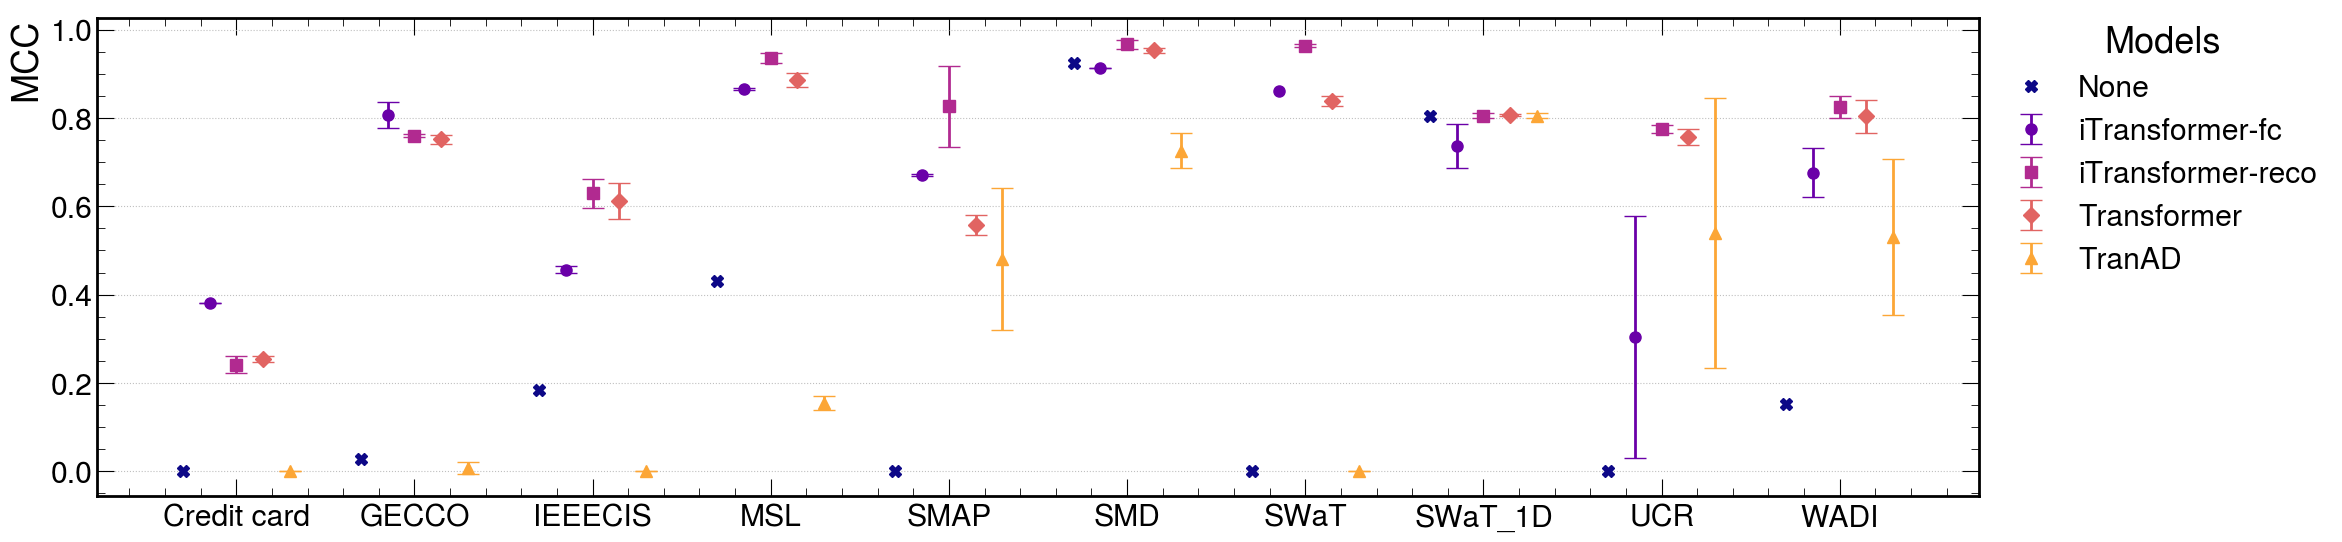

In [36]:
data_plot = datasets 
datanames = ['Credit card', 'GECCO', 'IEEECIS', 'MSL', 'SMAP', 'SMD', 'SWaT' ,'SWaT_1D', 'UCR', 'WADI']
# datanames = datasets
results_both = {}

for dataset in data_plot:
    print(f'Loading {dataset}')
    for modeltype in modeltypes:
        print(f'\tLoading {modeltype}')
        if reco:
            if modeltype == 'Transformer':
                results_both[f'{modeltype}_{dataset}'] = pd.read_csv(f'studies_paramsearch_reco/data/{dataset}_transformer_mcc.csv')
            elif modeltype == 'iTransformer-reco':
                chosen_config = pd.read_csv(f'studies_paramsearch_reco/configs/best_config_me.csv')
                chosen_config = chosen_config[chosen_config['dataset'] == dataset]
                results_tmp = pd.read_csv(f'studies_paramsearch_reco/data/{dataset}_mcc.csv')
                results_both[f'{modeltype}_{dataset}'] = results_tmp[results_tmp['model'] == chosen_config['model'].iloc[0]]
            elif modeltype == 'iTransformer-fc':
                chosen_config = pd.read_csv(f'studies_paramsearch_fc/configs/best_config_me.csv')
                chosen_config = chosen_config[chosen_config['dataset'] == dataset]
                results_tmp = pd.read_csv(f'studies_paramsearch_fc/data/{dataset}_mcc.csv')
                results_both[f'{modeltype}_{dataset}'] = results_tmp[results_tmp['model'] == chosen_config['model'].iloc[0]]
            elif modeltype == 'TranAD':
                if os.path.exists(f'studies_paramsearch_reco/data/{dataset}_TranAD_mcc.csv'):
                    results_both[f'{modeltype}_{dataset}'] = pd.read_csv(f'studies_paramsearch_reco/data/{dataset}_TranAD_mcc.csv')
                # if os.path.exists(f'studies_paramsearch_reco/data/{dataset}_TranAD_mcc.csv'):
                #     results_both[f'{modeltype}_{dataset}'] = pd.read_csv(f'studies_paramsearch_reco/data/{dataset}_TranAD_mcc.csv')
                # else:
                #     continue
            elif modeltype == 'None':
                if os.path.exists(f'studies_paramsearch_reco/data/{dataset}_None_mcc.csv'):
                    results_both[f'{modeltype}_{dataset}'] = pd.read_csv(f'studies_paramsearch_reco/data/{dataset}_None_mcc.csv')
                else:
                    continue
print('loading done')
    
print(results_both.keys())
# print(results_both['iTransformer-fc_creditcard_normal'])
compare_models(results_both, datasets, modeltypes, datanames, metric='MCC', safe=False, reco=reco)

In [ ]:
# Combine all results into a single DataFrame with an additional column for the keys
combined_results = []

for key, df in results_both.items():
    df['key'] = key  # Add a column for the key
    combined_results.append(df)

# Concatenate all DataFrames into one
combined_results_df = pd.concat(combined_results, ignore_index=True)

# Set 'key' as the index and drop 'Unnamed: 0' column
combined_results_df = combined_results_df.set_index('key').drop(columns=['Unnamed: 0'])

print(combined_results_df)
# combined_results_df.to_csv(f'studies_paramsearch_reco/configs/combined_results_transf_tranAD_eps10_none.csv')

                                               dataset  \
key                                                      
None_creditcard_normal               creditcard_normal   
iTransformer-fc_creditcard_normal    creditcard_normal   
iTransformer-reco_creditcard_normal  creditcard_normal   
Transformer_creditcard_normal        creditcard_normal   
TranAD_creditcard_normal             creditcard_normal   
None_GECCO_normal                         GECCO_normal   
iTransformer-fc_GECCO_normal              GECCO_normal   
iTransformer-reco_GECCO_normal            GECCO_normal   
Transformer_GECCO_normal                  GECCO_normal   
TranAD_GECCO_normal                       GECCO_normal   
None_IEEECIS_new2.2                     IEEECIS_new2.2   
iTransformer-fc_IEEECIS_new2.2          IEEECIS_new2.2   
iTransformer-reco_IEEECIS_new2.2        IEEECIS_new2.2   
Transformer_IEEECIS_new2.2              IEEECIS_new2.2   
TranAD_IEEECIS_new2.2                   IEEECIS_new2.2   
None_MSL_new  

/var/folders/mz/8xvqd9y134510qh2hy9fj_7c0000gn/T/ipykernel_17444/2001311978.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['key'] = key  # Add a column for the key


## compare anomaly labels

In [ ]:
datasets =  ['creditcard', 'creditcard_normal', 'GECCO', 'GECCO_normal', 'IEEECIS_new2.2', 'MSL_new', 'SMAP_new', 'SMD', 'SWaT', 'SWaT_1D', 'UCR', 'WADI']
# ['creditcard_normal', 'GECCO_normal', 'IEEECIS_new2.2', 'MSL_new', 'SMAP_new', 'SMD', 'SWaT', 'SWaT_1D', 'UCR', 'WADI']
# ['creditcard', 'creditcard_normal', 'GECCO', 'GECCO_normal', 'IEEECIS_new2.2', 'MSL_new', 'SMAP_new', 'SMD', 'SWaT', 'SWaT_1D', 'UCR', 'WADI']
modeltype = 'iTransformer'
reco = True

In [ ]:
colors = plt.cm.plasma(np.linspace(0, 1, 6))
plt.rcParams.update({'lines.markersize': 8})


for dataset in datasets:
    config = {}

    if dataset in ['SWaT_1D', 'UCR']:
        print(f'Skipping 1D datasets {dataset}')
        continue
    print(f'Loading {dataset}')
    if reco:
        if modeltype == 'Transformer':
            paths = glob.glob(f'{modeltype}/{modeltype}_{dataset}/*' )
        else:
            paths = glob.glob(f'{modeltype}_loss_fct/{modeltype}_{dataset}/*' )
    else:
        paths = glob.glob(f'{modeltype}_loss_fct/{modeltype}_{dataset}/*' )
    paths = [p for p in paths if not '.txt' in p]
    paths = [p for p in paths if not 'Huber' in p]
    paths = [p for p in paths if not 'Huber_quant' in p]
    paths = [p for p in paths if not 'penalty' in p]
    paths = sorted(paths)


    for path in paths:
        key = path.split('/')[2]
        path = glob.glob(f'{path}/rep_*/results/')  # will give all 5 repetitions
        path = sorted(path)
        # print(len(path))

        tmp = pd.DataFrame()
        fig = plt.figure(figsize=(20, 7), constrained_layout=True)
        for i, rep_path in enumerate(path):
            if not os.path.exists(rep_path):
                print(f'Skipping {key} rep {i+1}')
                continue
            res = pd.read_csv(os.path.join(rep_path, 'res_local_all.csv'))
            res_glob = pd.read_csv(os.path.join(rep_path, 'res.csv')).iloc[-2:]
            res.rename(columns={'Unnamed: 0': 'mode'}, inplace=True)
            res_glob.rename(columns={'Unnamed: 0': 'mode'}, inplace=True)
            res_glob.drop(columns=['threshold', 'Hit@100%', 'Hit@150%', 'NDCG@100%', 'NDCG@150%', 'train_time',
                            'train_loss', 'test_loss'], inplace=True)

            middle = math.ceil(res['mode'].iloc[-1]/2)
            nb_dims = res['mode'].iloc[-1]
            res = pd.concat((res, res_glob))
            res.loc[res.index[-2], 'mode'] = middle
            res.loc[res.index[-1], 'mode'] = nb_dims
            res.sort_values(by='mode', inplace=True)
            # print(res)

            plt.plot(res['mode'][:-1], res['MCC'][:-1], '-o', color=colors[i], label=f'local rep {i}')
            plt.plot(middle, res_glob['MCC'].iloc[-2], 's', color=colors[i], label=f'maj. voting rep {i}')
            plt.plot(nb_dims, res_glob['MCC'].iloc[-1], 'D', color=colors[i], label=f'global rep {i}')
            plt.ylim(top=1.0)
        plt.xlabel('# of dimensions used to declare anomaly')
        plt.ylabel('MCC')
        plt.title(f'{dataset} ({nb_dims} dimensions)')

        # Create legend handles for colors
        color_handles = [
            mpatches.Patch(color=colors[j], label=f'Run {j+1}') for j in range(5)
        ]
        # Create legend handles for marker shapes
        shape_handles = [
            mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=10, label=f'local'),
            mlines.Line2D([], [], color='black', marker='s', linestyle='None', markersize=10, label=f'maj. voting'),
            mlines.Line2D([], [], color='black', marker='D', linestyle='None', markersize=10, label=f'global'),
        ]

        # plt.legend(bbox_to_anchor=(0.7, 0.95), loc='upper left')
        if dataset in ['SMAP_new', 'SWaT']: 
            legend2 = plt.legend(handles=color_handles, title='Runs', bbox_to_anchor=(0.0, 0.0), loc='lower left')
            plt.gca().add_artist(legend2)  # Add the first legend manually to the axes  
            legend1 = plt.legend(handles=shape_handles, title='Anomaly labels', bbox_to_anchor=(0.15, 0.0), loc='lower left')  
        else:
            legend2 = plt.legend(handles=color_handles, title='Runs', bbox_to_anchor=(0.8, 1.0), loc='upper left')
            plt.gca().add_artist(legend2)  # Add the first legend manually to the axes
            legend1 = plt.legend(handles=shape_handles, title='Anomaly labels', bbox_to_anchor=(0.6, 1.0), loc='upper left')  
            
        plt.grid('gray', axis='y')
        # if reco:
        #     plt.savefig(f'studies_anomalylabels/{dataset}_reco.png', facecolor='w')
        # else:
        #     plt.savefig(f'studies_anomalylabels/{dataset}_fc.png', facecolor='w')
        plt.show()

            

### check whether there's correlations in training data that explains plots above

In [ ]:
from src.data_loader import MyDataset

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 

    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    return datax.corr(datay.shift(lag))

In [ ]:
for dataset in datasets:
    if dataset in ['SWaT_1D', 'UCR']:
        print(f'Skipping 1D datasets {dataset}')
        continue
    elif dataset in ['IEEECIS_new2.2', 'WADI']:
        feats = 30
    else:
        feats = -1

    print(f'\nLoading {dataset}')
    
    train = MyDataset(dataset, 10, 10, modeltype, flag='train', feats=feats, less=False, enc=False, k=-1)
    features = train.feats
    print(train.feats)
    train = train.get_complete_data()
    print(train.shape)

    # # do PCA
    # scaler = StandardScaler()
    # train_scaled = scaler.fit_transform(train)
    # pca = PCA()
    # pca.fit(train_scaled)
    # explained_variance = pca.explained_variance_ratio_
    # idx = np.where(np.cumsum(explained_variance) >= 0.9)[0][0]
    # print('how many PC needed to explain 90% of variance:', idx)

    # # Plot the explained variance summed
    # plt.figure(figsize=(10, 8))
    # plt.plot(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), marker='o', linestyle='--', label='Explained variance')
    # # plt.hlines(0.9, 0, len(explained_variance), color='black', alpha=0.8)
    # plt.axvline(x=np.where(np.cumsum(explained_variance) >= 0.9)[0][0], color='red', linestyle='dashed', label=rf'$\geq 90$% variance ($x={idx}$)')
    # plt.title(f'PCA Components for {dataset}')
    # plt.xlabel('Number of principal components')
    # plt.ylabel('Cumulative explained variance')
    # plt.legend()
    # plt.ylim(0.2, 1.0)
    # plt.grid()
    # plt.tight_layout()
    # plt.savefig(f'./studies_anomalylabels/pca_{dataset}.png', facecolor='w')
    # plt.show()

    constfeat = np.where(np.var(train, axis=0)==0)[0]
    print('constant feature:', constfeat)
    print(f'# of const features', len(constfeat))
    train = np.delete(train, constfeat, axis=1) 
    features = train.shape[1]
    # print(train.shape)
    # corr_matrix = np.corrcoef(train.T)

    # print(np.any(np.isnan(corr_matrix)))
    # # Count the number of columns that are very lowly correlated with all others
    # low_corr_cols = np.sum(np.mean(corr_matrix, axis=0) < 0.1)
    # print(f'Number of columns very lowly correlated with all others: {low_corr_cols}')
    # print(f'Indices of very lowly correlated columns: {np.where(np.mean(corr_matrix, axis=0) < 0.1)[0]}')
    
    # # Count the number of columns that are very highly correlated with all others
    # high_corr_cols =np.sum(np.mean(corr_matrix, axis=0) > 0.5)
    # print(f'Number of columns very highly correlated with all others: {high_corr_cols}')
    # print(f'Indices of very highly correlated columns: {np.where(np.mean(corr_matrix, axis=0) > 0.9)[0]}')

    # plt.imshow(corr_matrix, cmap='Blues', interpolation='nearest', vmin=0, vmax=1)
    # plt.colorbar(shrink=0.7)
    # plt.title(f'Correlation matrix for {dataset}')
    # # plt.xticks(ticks=np.arange(features), labels=np.arange(1, features + 1))
    # # plt.yticks(ticks=np.arange(features), labels=np.arange(1, features + 1))
    # plt.tight_layout()
    # # plt.savefig(f'./studies_anomalylabels/corr_matrix_{dataset}.png', facecolor='w')
    # plt.show()

    # cross correlation across dimensions
    crosscorr_matrix = np.zeros((features, features))
    for lag in [1, 5, 10, 20]:
        for i in range(features):
            for j in range(features):
                x = pd.Series(train[:, i])
                y = pd.Series(train[:, j])
                crosscorr_matrix[i, j] = crosscorr(x, y, lag=lag)
        low_corr_cols = np.sum(np.mean(crosscorr_matrix, axis=0) < 0.1)
        print(f'Number of columns very lowly correlated with all others: {low_corr_cols}')
        print(f'Indices of very lowly correlated columns: {np.where(np.mean(crosscorr_matrix, axis=0) < 0.1)[0]}')
        # Count the number of columns that are very highly correlated with all others
        high_corr_cols =np.sum(np.mean(crosscorr_matrix, axis=0) > 0.5)
        print(f'Number of columns very highly correlated with all others: {high_corr_cols}')
        print(f'Indices of very highly correlated columns: {np.where(np.mean(crosscorr_matrix, axis=0) > 0.9)[0]}')

    
        plt.imshow(crosscorr_matrix, cmap='Blues', interpolation='nearest', vmax=1)    
        plt.colorbar(shrink=0.7)
        plt.title(f'Cross-correlation matrix for {dataset}, lag={lag}')
        plt.tight_layout()
        plt.savefig(f'./studies_anomalylabels/cross_corr_matrix_{dataset}_lag{lag}.png', facecolor='w')
        plt.show()


## studies on IQR

In [ ]:
# Plotting the results for GECCO_normal data set
percentile = [0.001, 0.01, 0.1, 0.2, 0.4, 0.5, 0.6, 0.8, 0.99, 0.999]
mccscores = [0.426, 0.364, 0.623, 0.628, 0.652, 0.607, 0.558, 0.610, 0.574, 0.545]
mccscores2 = [0.398, 0.26, 0.575, 0.563, 0.377, 0.557, 0.533, 0.574, 0.337, 0.547]

plt.figure(figsize=(12,8))
plt.hlines(y=0.74, xmin=0, xmax=1, color='black', linestyle='--', label='anomaly score = MSE = $(y_{pred} - y_{true})^2$')
plt.plot(percentile, mccscores, '-o', label='anomaly score = $IQR_r = |y_{(1-r/2)} - y_{r/2}|$')
plt.plot(percentile, mccscores2, '-o', label='anomaly score = max$(|y_{pred} - y_{(1-r/2)}|, |y_{pred} - y_{r/2}|)$')
plt.legend()
plt.ylim(0.2, 1.)
plt.xlabel(r'Range $r$ for $IQR_r$')
plt.ylabel('MCC')
plt.title('GECCO_normal')
plt.grid('gray', axis='y')

In [ ]:
def compute_mcc(tp, tn, fp, fn):
    numerator = (tp * tn) - (fp * fn)
    denominator = ((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) ** 0.5
    if denominator == 0:
        return 0  # To handle division by zero
    return numerator / denominator

# Example usage:
# Confusion matrix values
## local incl or
# tp = 48023  # True Positives
# tn = 352809  # True Negatives
# fp = 27163  # False Positives
# fn = 7831   # False Negatives
# global
tp = 41442  # True Positives
tn = 371259 # True Negatives
fp = 8713  # False Positives
fn = 14412   # False Negatives


mcc = compute_mcc(tp, tn, fp, fn)
print(f"MCC Score: {mcc}")

In [ ]:
import torch.nn.functional as F 

In [ ]:
# # Define the range of x values
# x = torch.linspace(-4, 4, 100)

# # Compute activation function values
# y_relu = F.relu(x)
# y_leaky_relu = F.leaky_relu(x, negative_slope=0.1)
# y_sigmoid = torch.sigmoid(x)
# y_tanh = torch.tanh(x)
# y_elu = F.elu(x, alpha=1.0)
# y_softsign = F.softsign(x)
# # List of activation functions and their names
# activations = [
#     (y_relu, 'ReLU', r'$g(z) = $max$(0, z)$'),
#     (y_leaky_relu, 'Leaky ReLU', r'$g(z) = $ max$(0.1z, z)$'),
#     (y_sigmoid, 'Sigmoid', r'$g(z) = 1/(1+e^{-z})$'),
#     (y_tanh, 'Tanh', r'$g(z) = $tanh$(z)$'),
#     (y_elu, 'ELU', r'$g(z) = z$ if $z>0$'f'\n'r'$g(z)=e^z-1$ elsewhere'),
#     (y_softsign, 'Softsign', r'$g(z) = z/(1+|z|)$')
# ]
# # Create subplots
# fig, axes = plt.subplots(2, 3, figsize=(16, 10), sharex=True, sharey=True)
# axes = axes.ravel()

# colors = plt.cm.plasma(np.linspace(0, 1, len(activations)+1))

# for i, (y, name, equation) in enumerate(activations):
#     axes[i].plot(x.numpy(), y.numpy(), label=fr'{equation}', color=colors[i])
#     axes[i].axhline(0, color='black', linewidth=0.5, linestyle='--')
#     axes[i].axvline(0, color='black', linewidth=0.5, linestyle='--')
#     axes[i].legend(loc='upper left')
#     axes[i].grid()
#     axes[i].set_title(name)
# fig.supxlabel(r"$z$")
# fig.supylabel(r"Activation function $g(z)$")

# plt.tight_layout()
# plt.show()
